In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, models
import torchvision
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

import torch.optim as optim

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        

        self.labels_df = pd.read_csv(labels_csv)

        self.label_map = {row["FeatID"]: row["class"] for index, row in self.labels_df.iterrows()}
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.label_map)

    def __getitem__(self, idx):
        feat_id = list(self.label_map.keys())[idx]
        img_name = f"featID {feat_id}.png"
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        label = self.label_map[feat_id]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
image_directory = '/Users/karthik/GANS/4by4-TOPO-24X224/renamed_images'
labels_csv = '/Users/karthik/AeruginosaWithClass.csv'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Parameters**

In [5]:
n_epochs = 250

image_dim = 1*224*224

n_class = 5 

latent_dim = 100

lr = 0.0002

b1 = 0.5

b2 = 0.999

batch_size = 32

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
dataset = CustomDataset(image_directory, labels_csv, transform=transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for images, labels in data_loader:

    pass

In [8]:
total_images = len(dataset)
total_labels = len(set(dataset.labels_df['class']))  

print(f"Total images: {total_images}")
print(f"Total labels: {total_labels}")

Total images: 2100
Total labels: 5


In [9]:
total_batches = len(data_loader)
print(f"Total batches: {total_batches}")

Total batches: 66


In [10]:
for i, (images, labels) in enumerate(data_loader, 1):
    print(f"Batch {i} has {len(images)} images and {len(labels)} labels")
    
    break

Batch 1 has 32 images and 32 labels


**Creating a Loop over the data loader to get the labels in the first batch**

In [11]:
first_batch_labels = next(iter(data_loader))[1] 

print("Labels in the first batch:")
print(first_batch_labels)

Labels in the first batch:
tensor([3, 2, 0, 2, 0, 4, 3, 3, 0, 0, 1, 1, 3, 1, 2, 1, 2, 0, 3, 1, 3, 2, 1, 0,
        1, 1, 3, 4, 1, 1, 1, 1])


**Generator Architecture**

In [12]:

class Generator(nn.Module):
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(n_class, n_class)

        # Define the fully connected layers
        self.fc1 = nn.Linear(latent_dim + n_class, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, image_dim)

    def forward(self, noise, labels):
        
        # Concatenate label embedding and image to produce input
        x = torch.cat((self.label_emb(labels), noise), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)

        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)

        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        
        x = self.fc4(x)
        x = F.leaky_relu(x, 0.2)

        x = self.fc5(x)
        img = torch.tanh(x)
        
        img = img.view(img.size(0), image_dim)
        return img

**Discriminator Architecture**

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_class, n_class)

        self.model = nn.Sequential(
            nn.Linear(n_class + image_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), dim= -1)
        validity = self.model(d_in)
        return validity

**Optiminser**

In [14]:
adversarial_loss = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

In [15]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

**Tensorboard Summary**

In [16]:
from torch.utils.tensorboard import SummaryWriter 

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

**Training Loop**

In [17]:
fixed_noise = torch.randn(16, latent_dim, device=device)  
fixed_labels = torch.randint(0, n_class, (16,), device=device)

In [18]:
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [19]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = FloatTensor(batch_size, 1).fill_(1.0)
        fake = FloatTensor(batch_size, 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(FloatTensor)
        labels = labels.type(LongTensor)

        # Training Generator
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        gen_labels = LongTensor(np.random.randint(0, n_class, batch_size))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # Training Discriminator
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
    if epoch % 5 == 0:

        print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
        )

[Epoch 0/250] [Batch 65/66] [D loss: 0.389847] [G loss: 0.716650]
[Epoch 5/250] [Batch 65/66] [D loss: 0.184095] [G loss: 1.391759]
[Epoch 10/250] [Batch 65/66] [D loss: 0.396645] [G loss: 1.130911]
[Epoch 15/250] [Batch 65/66] [D loss: 0.220653] [G loss: 1.285694]
[Epoch 20/250] [Batch 65/66] [D loss: 0.224134] [G loss: 1.626510]
[Epoch 25/250] [Batch 65/66] [D loss: 0.174817] [G loss: 1.396739]
[Epoch 30/250] [Batch 65/66] [D loss: 0.219791] [G loss: 1.942509]
[Epoch 35/250] [Batch 65/66] [D loss: 0.383270] [G loss: 1.694596]
[Epoch 40/250] [Batch 65/66] [D loss: 0.413921] [G loss: 2.200932]
[Epoch 45/250] [Batch 65/66] [D loss: 0.375498] [G loss: 2.171028]
[Epoch 50/250] [Batch 65/66] [D loss: 0.224549] [G loss: 2.173066]
[Epoch 55/250] [Batch 65/66] [D loss: 0.564221] [G loss: 1.144127]
[Epoch 60/250] [Batch 65/66] [D loss: 0.380938] [G loss: 1.350109]
[Epoch 65/250] [Batch 65/66] [D loss: 0.351952] [G loss: 1.706303]
[Epoch 70/250] [Batch 65/66] [D loss: 0.485239] [G loss: 1.38078

**To Generate Specific Sample Images**

In [20]:
import torch

# Define the specific label and the number of images you want to generate
specific_label = 0
num_images = 16  # Example: generate 5 images

# Assuming you're using a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate noise vectors
noise = torch.randn(num_images, latent_dim).to(device)

# Create label tensor (all elements are the specific label)
labels = torch.full((num_images,), specific_label, dtype=torch.long).to(device)

# Generate images
with torch.no_grad():
    generated_images = generator(noise, labels)

**To Visualise the Generated Image**

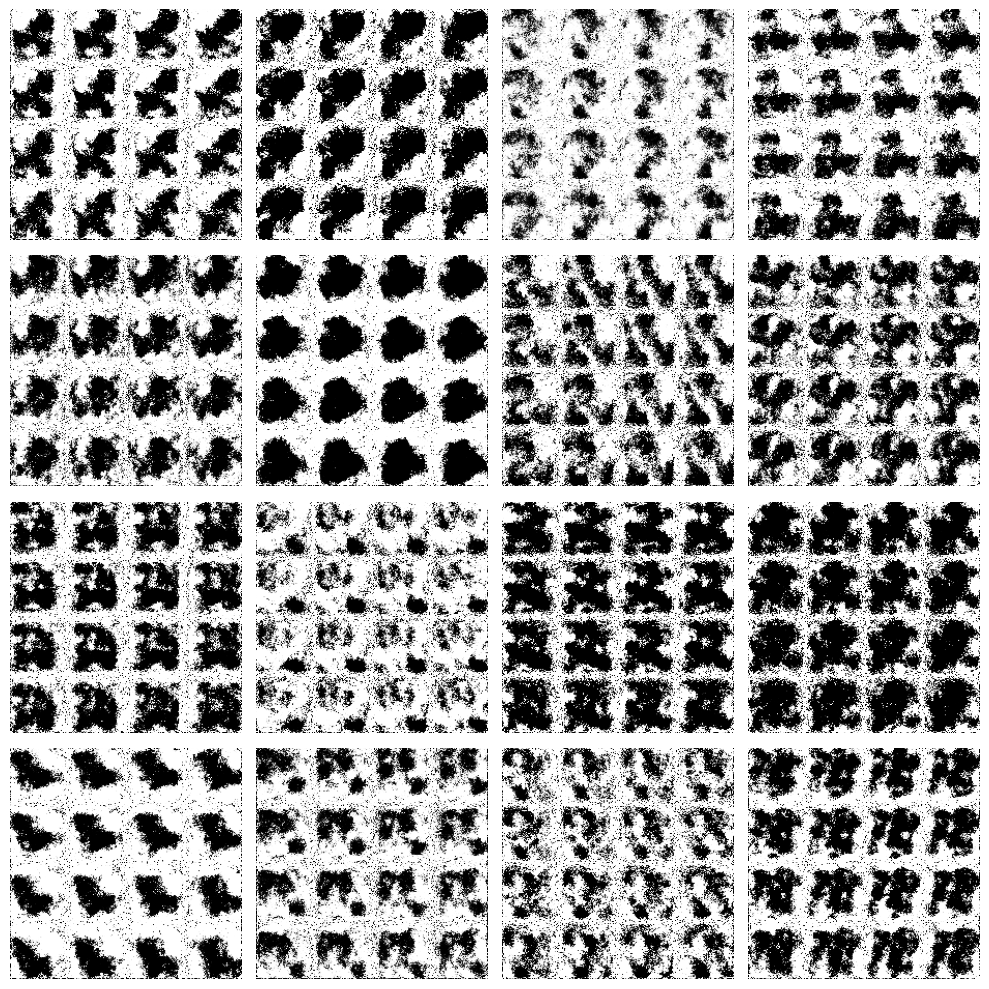

In [21]:
import matplotlib.pyplot as plt

# Assuming generated_images is a batch of images
num_images = 16
rows = 4
cols = 4  # 4x4 grid for 16 images

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, img in enumerate(generated_images):
    ax = axes[i // cols, i % cols]  # Determine the row and column

    # Reshape the image from (50176,) to (224, 224) and normalize it to [0, 1]
    img = img.view(224, 224)  # Reshape
    img = (img + 1) / 2       # Normalize
    img = img.clamp(0, 1)
    img = img.cpu()

    # Display the image
    ax.imshow(img.numpy(), cmap='gray')
    ax.axis('off')  # Hide axes

# Ensure there are no empty plots if there are fewer than 16 images
for i in range(len(generated_images), rows * cols):
    axes[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()
